<a href="https://colab.research.google.com/github/PGV1000/data_mining/blob/main/%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%9F%D0%A0_%E2%84%9611_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2%2C_%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D1%8F_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая №11. Прогнозирование временных рядов, используя методы глубокого обучения**

Задание:
1. Ознакомьтесь с библиотеками и их инструментарием
2. В контексте выбранного Вами набора данных, отберите несколько моделей глубокого обучения, обучите их на своих данных, после чего проведите сравнительный анализ.

## **Подготовка данных**

Датасет: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

In [ ]:
%%capture
!pip install pandas-datareader
!pip install nbeats-keras
!pip install plotly
!pip install pycountry
!pip install tensorflow
!pip install darts

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from darts.models import NBEATSModel
from darts import TimeSeries
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("twinkle0705/state-wise-power-consumption-in-india")
!cp -r {path} .
print("Path to dataset files:", path)

100%|██████████| 123k/123k [00:00<00:00, 33.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/twinkle0705/state-wise-power-consumption-in-india/versions/3


In [ ]:
ds = pd.read_csv('/content/3/dataset_tk.csv')

ds.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
ds['DateTime'] = pd.to_datetime(ds['DateTime'], format='%d/%m/%Y %H:%M:%S')

data = ds['Delhi'].values.astype('float32').reshape(-1, 1)

print("Количество НАН в Дели:", np.isnan(data).sum())
print("Колифество беск в ДЕли:", np.isinf(data).sum())

data = data[~np.isnan(data).any(axis=1) & ~np.isinf(data).any(axis=1)]


scaler_target = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_target.fit_transform(data)
print("минимальное значчение до скейла:", data.min())
print("Максимальное значение до скейла:", data.max())
print("минимальное значчение после скейла:", data_scaled.min())
print("Максимальное значчение после скейла:", data_scaled.max())
print("Стандартное отклонение:", np.std(data_scaled))

noise = np.random.normal(0, 0.01, data_scaled.shape)
data_scaled_noisy = np.clip(data_scaled + noise, 0, 1)
print("Стандартное отклонение после шума:", np.std(data_scaled_noisy))

train_size = int(len(data_scaled_noisy) * 0.8)
train, test = data_scaled_noisy[0:train_size, :], data_scaled_noisy[train_size:, :]

def create_sequences(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 6
X_train, Y_train = create_sequences(train, look_back)
X_test, Y_test = create_sequences(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("X_train шейп:", X_train.shape)
print("Y_train шейп:", Y_train.shape)
print("X_test шейп:", X_test.shape)
print("Y_test шейп:", Y_test.shape)

Количество НАН в Дели: 0
Колифество беск в ДЕли: 0
минимальное значчение до скейла: 41.8
Максимальное значение до скейла: 147.1
минимальное значчение после скейла: 0.0
Максимальное значчение после скейла: 1.0
Стандартное отклонение: 0.24586497
Стандартное отклонение после шума: 0.24637706518611144
X_train шейп: (396, 6, 1)
Y_train шейп: (396,)
X_test шейп: (95, 6, 1)
Y_test шейп: (95,)


In [ ]:
from darts import TimeSeries


train_series = TimeSeries.from_values(train.flatten())
test_series = TimeSeries.from_values(test.flatten())

# Проверка длин
print("Размер обучающей выборки:", len(train_series))
print("Размер тестовой выборки:", len(test_series))

Размер обучающей выборки: 402
Размер тестовой выборки: 101


Epoch 1/10
13/13 - 2s - 187ms/step - loss: 0.1651 - val_loss: 0.1130
Epoch 2/10
13/13 - 0s - 10ms/step - loss: 0.0649 - val_loss: 0.0776
Epoch 3/10
13/13 - 0s - 13ms/step - loss: 0.0461 - val_loss: 0.0645
Epoch 4/10
13/13 - 0s - 21ms/step - loss: 0.0394 - val_loss: 0.0579
Epoch 5/10
13/13 - 0s - 10ms/step - loss: 0.0354 - val_loss: 0.0532
Epoch 6/10
13/13 - 0s - 10ms/step - loss: 0.0328 - val_loss: 0.0513
Epoch 7/10
13/13 - 0s - 11ms/step - loss: 0.0310 - val_loss: 0.0472
Epoch 8/10
13/13 - 0s - 11ms/step - loss: 0.0289 - val_loss: 0.0451
Epoch 9/10
13/13 - 0s - 10ms/step - loss: 0.0282 - val_loss: 0.0433
Epoch 10/10
13/13 - 0s - 13ms/step - loss: 0.0261 - val_loss: 0.0412
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

RNN Results:
Train RMSE: 16.75
Test RMSE: 21.38
Train MAE: 12.55
Test MAE: 14.99


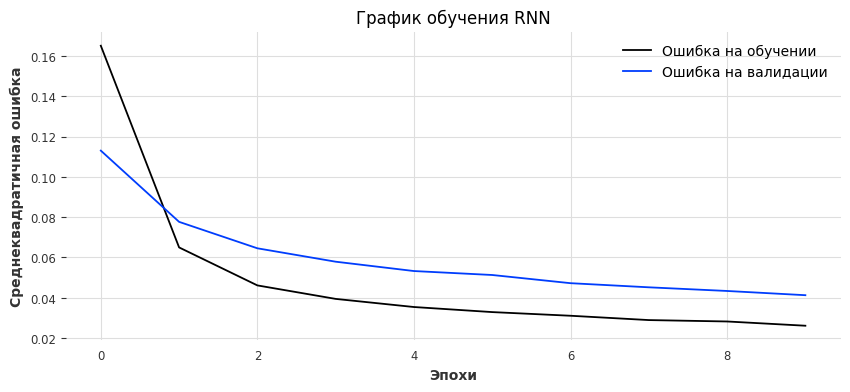

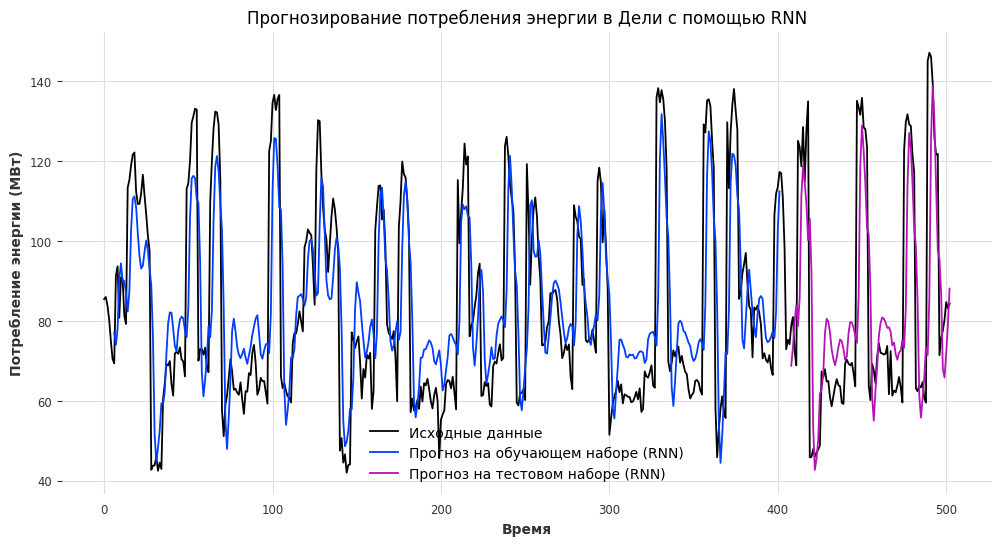

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(look_back, 1)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')


history_rnn = model_rnn.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)

train_predict_rnn = scaler_target.inverse_transform(train_predict_rnn)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
test_predict_rnn = scaler_target.inverse_transform(test_predict_rnn)
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

train_rmse_rnn = np.sqrt(mean_squared_error(Y_train_actual, train_predict_rnn))
test_rmse_rnn = np.sqrt(mean_squared_error(Y_test_actual, test_predict_rnn))
train_mae_rnn = mean_absolute_error(Y_train_actual, train_predict_rnn)
test_mae_rnn = mean_absolute_error(Y_test_actual, test_predict_rnn)

print("\nRNN Results:")
print(f"Train RMSE: {train_rmse_rnn:.2f}")
print(f"Test RMSE: {test_rmse_rnn:.2f}")
print(f"Train MAE: {train_mae_rnn:.2f}")
print(f"Test MAE: {test_mae_rnn:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(history_rnn.history['loss'], label='Ошибка на обучении')
plt.plot(history_rnn.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения RNN')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

train_predict_plot = np.empty_like(full_dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_rnn) + look_back, :] = train_predict_rnn

test_predict_plot = np.empty_like(full_dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_rnn) + (look_back * 2):len(full_dataset), :] = test_predict_rnn

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(train_predict_plot, label='Прогноз на обучающем наборе (RNN)')
plt.plot(test_predict_plot, label='Прогноз на тестовом наборе (RNN)')
plt.title('Прогнозирование потребления энергии в Дели с помощью RNN')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.legend()
plt.show()

Epoch 1/30
13/13 - 6s - 473ms/step - loss: 0.1218 - val_loss: 0.1028
Epoch 2/30
13/13 - 1s - 46ms/step - loss: 0.0599 - val_loss: 0.0884
Epoch 3/30
13/13 - 0s - 20ms/step - loss: 0.0570 - val_loss: 0.0823
Epoch 4/30
13/13 - 0s - 23ms/step - loss: 0.0532 - val_loss: 0.0813
Epoch 5/30
13/13 - 0s - 23ms/step - loss: 0.0530 - val_loss: 0.0802
Epoch 6/30
13/13 - 0s - 22ms/step - loss: 0.0524 - val_loss: 0.0795
Epoch 7/30
13/13 - 0s - 22ms/step - loss: 0.0518 - val_loss: 0.0787
Epoch 8/30
13/13 - 0s - 21ms/step - loss: 0.0522 - val_loss: 0.0779
Epoch 9/30
13/13 - 0s - 24ms/step - loss: 0.0513 - val_loss: 0.0759
Epoch 10/30
13/13 - 0s - 22ms/step - loss: 0.0500 - val_loss: 0.0738
Epoch 11/30
13/13 - 0s - 23ms/step - loss: 0.0494 - val_loss: 0.0711
Epoch 12/30
13/13 - 0s - 22ms/step - loss: 0.0469 - val_loss: 0.0695
Epoch 13/30
13/13 - 0s - 35ms/step - loss: 0.0452 - val_loss: 0.0605
Epoch 14/30
13/13 - 1s - 44ms/step - loss: 0.0386 - val_loss: 0.0565
Epoch 15/30
13/13 - 1s - 48ms/step - loss:

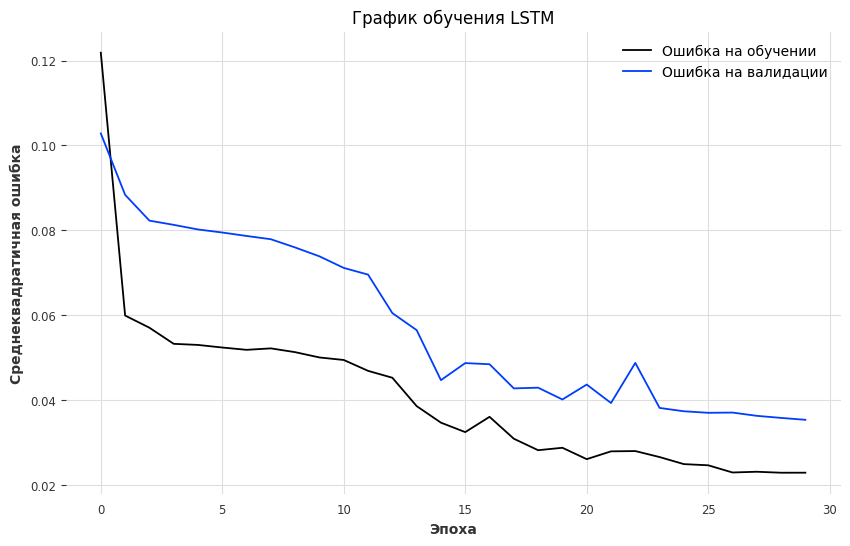

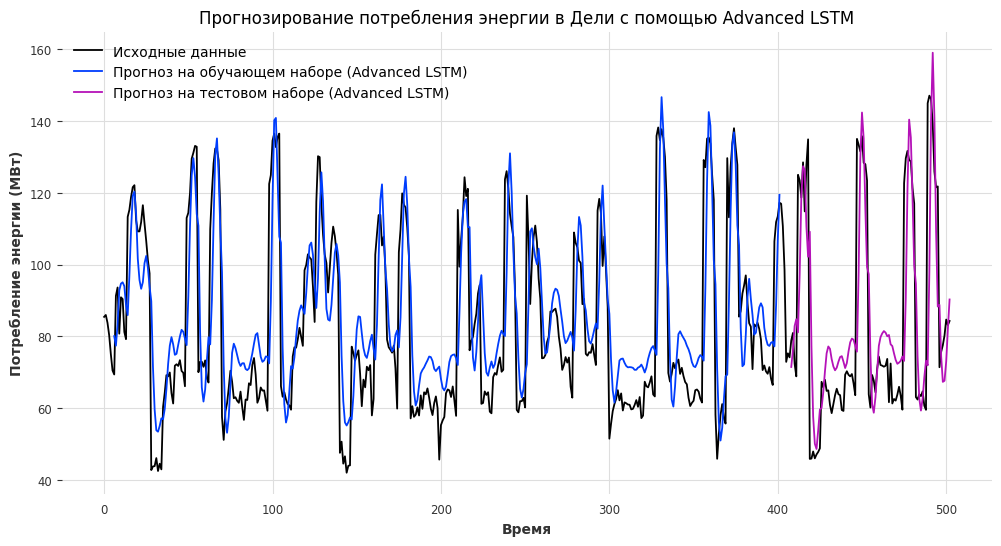

In [ ]:
from tensorflow.keras.layers import Dropout

model_lstm_advanced = Sequential()
model_lstm_advanced.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
model_lstm_advanced.add(Dropout(0.2))
model_lstm_advanced.add(LSTM(50, return_sequences=True))
model_lstm_advanced.add(Dropout(0.2))
model_lstm_advanced.add(LSTM(25))
model_lstm_advanced.add(Dense(1))
model_lstm_advanced.compile(loss='mean_squared_error', optimizer='adam')

history_lstm_advanced = model_lstm_advanced.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

train_predict_lstm_advanced = model_lstm_advanced.predict(X_train)
test_predict_lstm_advanced = model_lstm_advanced.predict(X_test)

train_predict_lstm_advanced = scaler_target.inverse_transform(train_predict_lstm_advanced)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
test_predict_lstm_advanced = scaler_target.inverse_transform(test_predict_lstm_advanced)
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

train_rmse_lstm_advanced = np.sqrt(mean_squared_error(Y_train_actual, train_predict_lstm_advanced))
test_rmse_lstm_advanced = np.sqrt(mean_squared_error(Y_test_actual, test_predict_lstm_advanced))
train_mae_lstm_advanced = mean_absolute_error(Y_train_actual, train_predict_lstm_advanced)
test_mae_lstm_advanced = mean_absolute_error(Y_test_actual, test_predict_lstm_advanced)

print("\nAdvanced LSTM Results:")
print(f"Train RMSE: {train_rmse_lstm_advanced:.2f}")
print(f"Test RMSE: {test_rmse_lstm_advanced:.2f}")
print(f"Train MAE: {train_mae_lstm_advanced:.2f}")
print(f"Test MAE: {test_mae_lstm_advanced:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(history_lstm_advanced.history['loss'], label='Ошибка на обучении')
plt.plot(history_lstm_advanced.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения LSTM')
plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

train_predict_plot = np.empty_like(full_dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_lstm_advanced) + look_back, :] = train_predict_lstm_advanced

test_predict_plot = np.empty_like(full_dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_lstm_advanced) + (look_back * 2):len(full_dataset), :] = test_predict_lstm_advanced

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(train_predict_plot, label='Прогноз на обучающем наборе (Advanced LSTM)')
plt.plot(test_predict_plot, label='Прогноз на тестовом наборе (Advanced LSTM)')
plt.title('Прогнозирование потребления энергии в Дели с помощью Advanced LSTM')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.legend()
plt.show()

Epoch 1/30
13/13 - 3s - 226ms/step - loss: 0.0856 - val_loss: 0.0598
Epoch 2/30
13/13 - 0s - 13ms/step - loss: 0.0394 - val_loss: 0.0579
Epoch 3/30
13/13 - 0s - 23ms/step - loss: 0.0346 - val_loss: 0.0532
Epoch 4/30
13/13 - 0s - 24ms/step - loss: 0.0327 - val_loss: 0.0506
Epoch 5/30
13/13 - 0s - 29ms/step - loss: 0.0306 - val_loss: 0.0475
Epoch 6/30
13/13 - 0s - 25ms/step - loss: 0.0288 - val_loss: 0.0448
Epoch 7/30
13/13 - 0s - 20ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 8/30
13/13 - 0s - 22ms/step - loss: 0.0252 - val_loss: 0.0395
Epoch 9/30
13/13 - 0s - 27ms/step - loss: 0.0235 - val_loss: 0.0371
Epoch 10/30
13/13 - 0s - 19ms/step - loss: 0.0220 - val_loss: 0.0351
Epoch 11/30
13/13 - 0s - 26ms/step - loss: 0.0212 - val_loss: 0.0338
Epoch 12/30
13/13 - 0s - 22ms/step - loss: 0.0203 - val_loss: 0.0336
Epoch 13/30
13/13 - 0s - 22ms/step - loss: 0.0199 - val_loss: 0.0328
Epoch 14/30
13/13 - 0s - 17ms/step - loss: 0.0195 - val_loss: 0.0326
Epoch 15/30
13/13 - 0s - 16ms/step - loss:

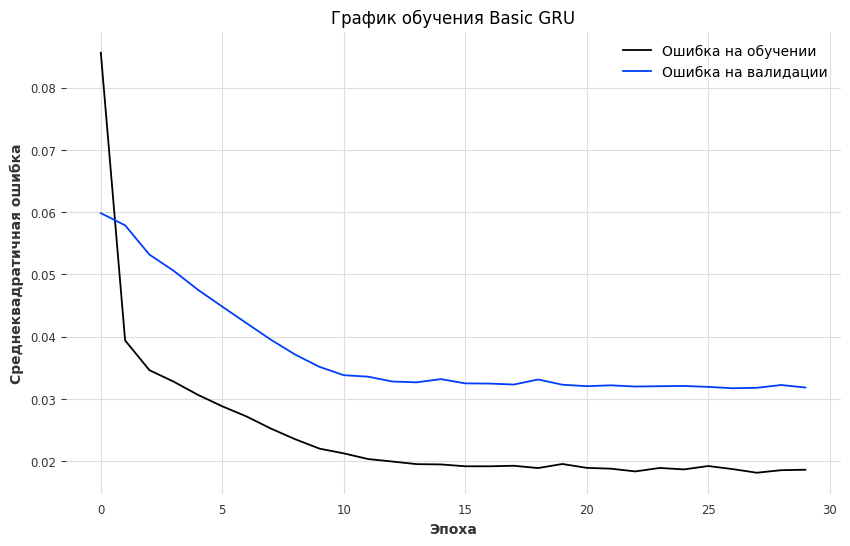

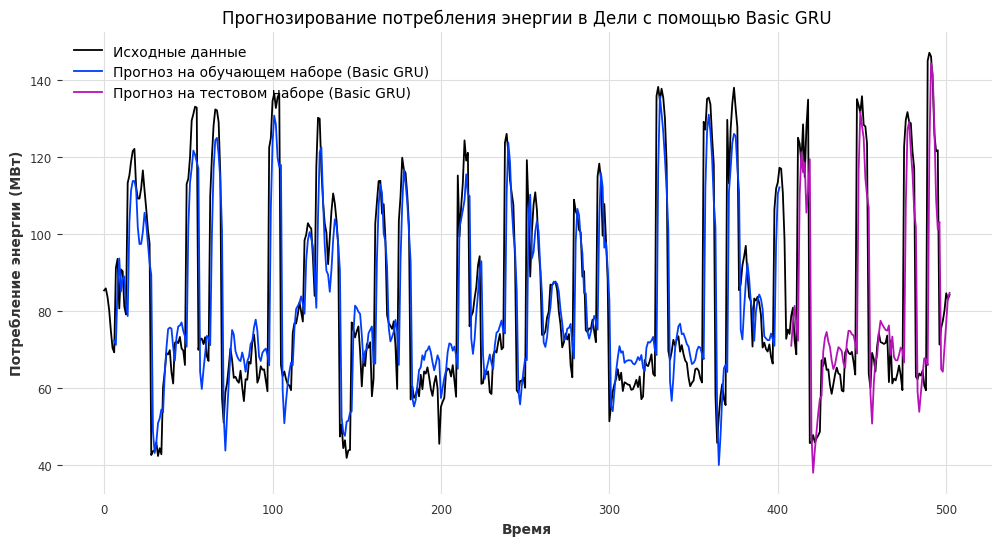

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_gru_basic = Sequential()
model_gru_basic.add(GRU(50, input_shape=(look_back, 1)))
model_gru_basic.add(Dense(1))
model_gru_basic.compile(loss='mean_squared_error', optimizer='adam')

history_gru_basic = model_gru_basic.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

train_predict_gru_basic = model_gru_basic.predict(X_train)
test_predict_gru_basic = model_gru_basic.predict(X_test)

train_predict_gru_basic = scaler_target.inverse_transform(train_predict_gru_basic)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
test_predict_gru_basic = scaler_target.inverse_transform(test_predict_gru_basic)
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

train_rmse_gru_basic = np.sqrt(mean_squared_error(Y_train_actual, train_predict_gru_basic))
test_rmse_gru_basic = np.sqrt(mean_squared_error(Y_test_actual, test_predict_gru_basic))
train_mae_gru_basic = mean_absolute_error(Y_train_actual, train_predict_gru_basic)
test_mae_gru_basic = mean_absolute_error(Y_test_actual, test_predict_gru_basic)

print("\nBasic GRU Results:")
print(f"Train RMSE: {train_rmse_gru_basic:.2f}")
print(f"Test RMSE: {test_rmse_gru_basic:.2f}")
print(f"Train MAE: {train_mae_gru_basic:.2f}")
print(f"Test MAE: {test_mae_gru_basic:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(history_gru_basic.history['loss'], label='Ошибка на обучении')
plt.plot(history_gru_basic.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения Basic GRU')
plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

train_predict_plot = np.empty_like(full_dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_gru_basic) + look_back, :] = train_predict_gru_basic

test_predict_plot = np.empty_like(full_dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_gru_basic) + (look_back * 2):len(full_dataset), :] = test_predict_gru_basic

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(train_predict_plot, label='Прогноз на обучающем наборе (Basic GRU)')
plt.plot(test_predict_plot, label='Прогноз на тестовом наборе (Basic GRU)')
plt.title('Прогнозирование потребления энергии в Дели с помощью Basic GRU')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.legend()
plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 120    | train
-------------------------------------------------------------
59        Trainable params
61        Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NaN in train_predict_nbeats: 0
NaN in test_predict_nbeats: 0

N-BEATS Results:
Train RMSE: 25.24
Test RMSE: 30.82
Train MAE: 21.01
Test MAE: 25.16


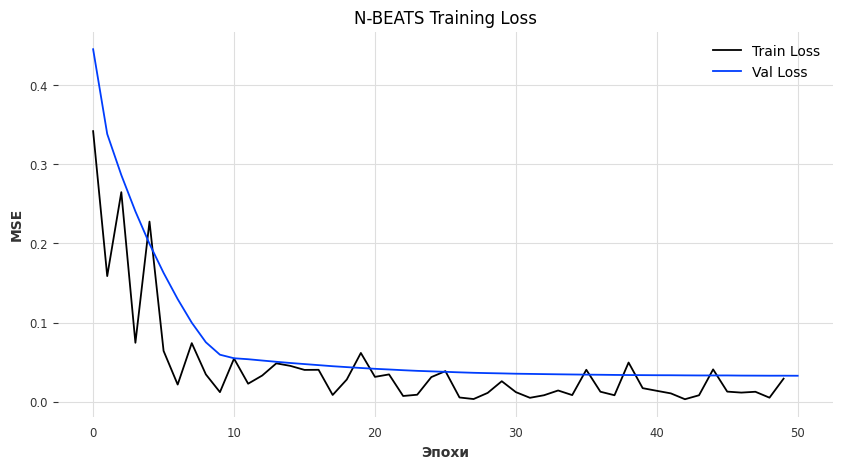

In [ ]:
from darts.models import NBEATSModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

loss_logger = LossLogger()
model_nbeats = NBEATSModel(
    input_chunk_length=look_back,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=1,
    num_blocks=1,
    num_layers=1,
    layer_widths=4,
    dropout=0.2,
    n_epochs=50,
    random_state=42,
    pl_trainer_kwargs={
        "callbacks": [loss_logger],
        "enable_progress_bar": True,
        "gradient_clip_val": 0.5,
        "accelerator": "cpu",
        "devices": 1
    }
)

model_nbeats.fit(
    series=train_series,
    val_series=test_series,
    verbose=True
)

train_predict_nbeats = model_nbeats.predict(n=len(train_series) - look_back, series=train_series[:look_back]).values()
test_predict_nbeats = model_nbeats.predict(n=len(test_series) - look_back, series=test_series[:look_back]).values()

print("NaN in train_predict_nbeats:", np.isnan(train_predict_nbeats).sum())
print("NaN in test_predict_nbeats:", np.isnan(test_predict_nbeats).sum())
train_predict_nbeats = np.nan_to_num(train_predict_nbeats, nan=np.mean(data_scaled_noisy))
test_predict_nbeats = np.nan_to_num(test_predict_nbeats, nan=np.mean(data_scaled_noisy))

train_predict_nbeats = scaler_target.inverse_transform(train_predict_nbeats)
test_predict_nbeats = scaler_target.inverse_transform(test_predict_nbeats)

train_actual_nbeats = scaler_target.inverse_transform(train_series.values()[look_back:])
test_actual_nbeats = scaler_target.inverse_transform(test_series.values()[look_back:])

train_rmse_nbeats = np.sqrt(mean_squared_error(train_actual_nbeats, train_predict_nbeats))
test_rmse_nbeats = np.sqrt(mean_squared_error(test_actual_nbeats, test_predict_nbeats))
train_mae_nbeats = mean_absolute_error(train_actual_nbeats, train_predict_nbeats)
test_mae_nbeats = mean_absolute_error(test_actual_nbeats, test_predict_nbeats)

print("\nN-BEATS Results:")
print(f"Train RMSE: {train_rmse_nbeats:.2f}")
print(f"Test RMSE: {test_rmse_nbeats:.2f}")
print(f"Train MAE: {train_mae_nbeats:.2f}")
print(f"Test MAE: {test_mae_nbeats:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_logger.train_losses, label='Train Loss')
plt.plot(loss_logger.val_losses, label='Val Loss')
plt.title('N-BEATS Training Loss')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.legend()
plt.savefig('nbeats_training_loss.png')
plt.show()

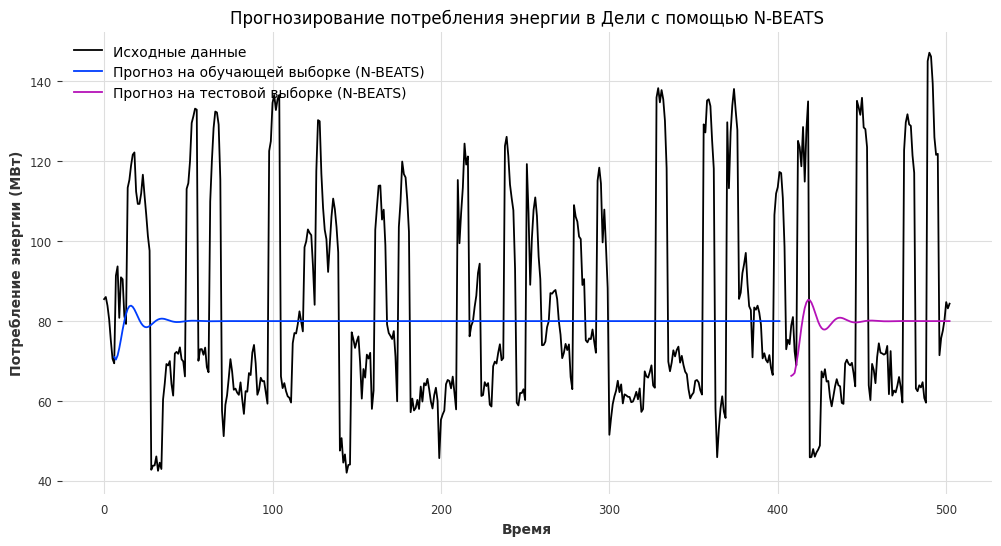

In [ ]:
full_dataset = np.vstack([train_series.values(), test_series.values()])
trainPredictPlot = np.empty_like(full_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_nbeats) + look_back, 0] = train_predict_nbeats[:, 0]

testPredictPlot = np.empty_like(full_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_nbeats) + (look_back * 2):len(full_dataset), 0] = test_predict_nbeats[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(trainPredictPlot, label='Прогноз на обучающей выборке (N-BEATS)')
plt.plot(testPredictPlot, label='Прогноз на тестовой выборке (N-BEATS)')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.title('Прогнозирование потребления энергии в Дели с помощью N-BEATS')
plt.legend()
plt.show()

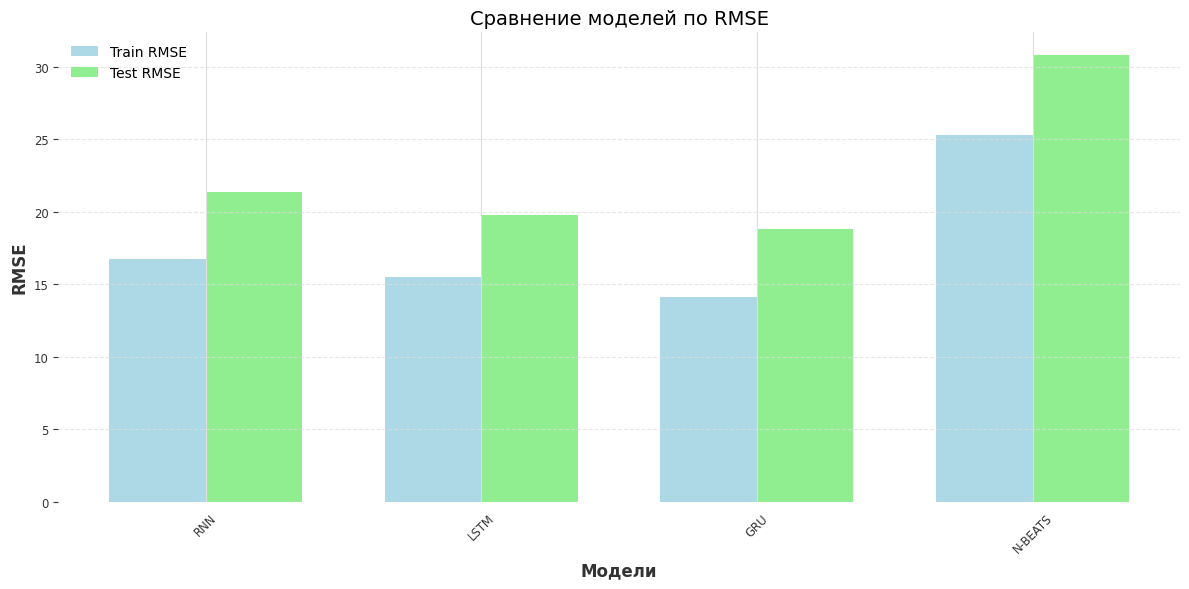

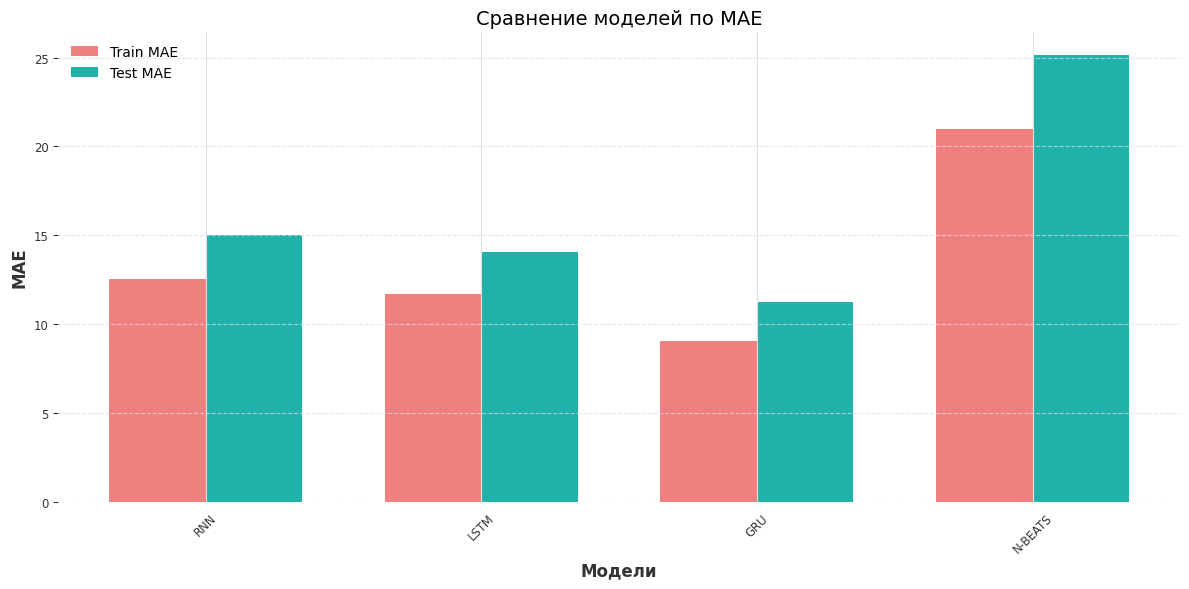

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['RNN', 'LSTM', 'GRU', 'N-BEATS']

train_rmse = [train_rmse_rnn, train_rmse_lstm_advanced, train_rmse_gru_basic, train_rmse_nbeats]
test_rmse = [test_rmse_rnn, test_rmse_lstm_advanced, test_rmse_gru_basic, test_rmse_nbeats]
train_mae = [train_mae_rnn, train_mae_lstm_advanced, train_mae_gru_basic, train_mae_nbeats]
test_mae = [test_mae_rnn, test_mae_lstm_advanced, test_mae_gru_basic, test_mae_nbeats]

bar_width = 0.35

x = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, train_rmse, width=bar_width, label='Train RMSE', color='lightblue')
plt.bar(x + bar_width / 2, test_rmse, width=bar_width, label='Test RMSE', color='lightgreen')
plt.xlabel('Модели', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Сравнение моделей по RMSE', fontsize=14)
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, train_mae, width=bar_width, label='Train MAE', color='lightcoral')
plt.bar(x + bar_width / 2, test_mae, width=bar_width, label='Test MAE', color='lightseagreen')
plt.xlabel('Модели', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Сравнение моделей по MAE', fontsize=14)
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()